In [95]:
import geopandas as gpd
import pandas as pd
from covid19dh import covid19
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [96]:
ilshps = gpd.read_file('../raw data/IL_BNDY_County/IL_BNDY_County_Py.shp')

In [97]:
ilshps.CO_FIPS = ilshps.CO_FIPS.astype(str).str.zfill(3).apply(lambda x: '17' + x)

In [98]:
gdf = ilshps.copy()
gdf['fips'] = gdf['CO_FIPS']
gdf

,COUNTY_NAM,CO_FIPS,geometry,fips
0,MCHENRY,17111,"POLYGON ((-88.70742 42.49351, -88.68809 42.493...",17111
1,BOONE,17007,"POLYGON ((-88.70742 42.49351, -88.7074 42.4934...",17007
2,OGLE,17141,"POLYGON ((-89.68808 42.19949, -89.66846 42.200...",17141
3,WILL,17197,"POLYGON ((-88.26146 41.72439, -88.26146 41.724...",17197
4,LASALLE,17099,"POLYGON ((-88.93885 41.62836, -88.93871 41.628...",17099
...,...,...,...,...
97,JEFFERSON,17081,"POLYGON ((-89.14445 38.47386, -89.12638 38.473...",17081
98,LAWRENCE,17101,"POLYGON ((-87.90805 38.85012, -87.88944 38.849...",17101
99,MARION,17121,"POLYGON ((-89.13843 38.73632, -89.13827 38.750...",17121
100,UNION,17181,"POLYGON ((-89.04143 37.59649, -89.04143 37.596...",17181


In [99]:
gdf = gdf.to_crs('EPSG:5070')

In [100]:
il_county_adj_matrix_base = pd.read_csv('../processed data/border_adj_matrix.csv', index_col=0)
il_county_adj_matrix_airport = pd.read_csv('../processed data/major_airports_adj_matrix.csv', index_col=0)
il_county_adj_matrix_highway = pd.read_csv('../processed data/highway_adj_matrix.csv', index_col=0)

98037

In [33]:
def linear_comb(border_weight, airport_weight, highway_weight, non_linear_border_weight=None):
    if non_linear_border_weight:
        return (il_county_adj_matrix_base.map(lambda x: non_linear_border_weight(float(x) + 1)) * border_weight +
                airport_weight * il_county_adj_matrix_airport.map(lambda x: float(x)) +
                highway_weight * il_county_adj_matrix_highway.map(lambda x: float(x)))
    else:
        return (il_county_adj_matrix_base.map(lambda x: float(x)) * border_weight + 
                airport_weight * il_county_adj_matrix_airport.map(lambda x: float(x)) + 
                highway_weight * il_county_adj_matrix_highway.map(lambda x: float(x)))

In [103]:
# A = linear_comb(0.1, 2500, 1000)
A = linear_comb(1/il_county_adj_matrix_base.max().max(), 1, 1/il_county_adj_matrix_highway.max().max(), None)

In [107]:
A.index = A.index.astype(str)
A.columns = A.columns.astype(str)

In [108]:
G = nx.from_pandas_adjacency(A)

In [109]:
rep = gdf[['fips','geometry']].copy()
rep['geometry'] = rep.geometry.representative_point()
pos = {r.fips: (r.geometry.x, r.geometry.y) for r in rep.itertuples()}


In [110]:
edges = []
Ai = A.values
idx = A.index.to_list()
for i in range(len(idx)):
    for j in range(i+1, len(idx)):
        w = Ai[i, j]
        if w != 0 and np.isfinite(w):
            edges.append((idx[i], idx[j], float(w)))


In [111]:
if edges:
    weights = np.array([w for _,_,w in edges], dtype=float)
    wmin, wmax = float(np.nanmin(weights)), float(np.nanmax(weights))
    # linewidths (clipped)
    lw = (0.6 + 5.4*(weights - wmin)/(wmax - wmin)) if wmax > wmin else np.full_like(weights, 2.0)
    # colors
    cmap = get_cmap('viridis')
    norm = Normalize(vmin=wmin, vmax=wmax)
    edge_colors = [cmap(norm(w)) for w in weights]
else:
    lw, edge_colors = [], []


C:\Users\hkdeb\AppData\Local\Temp\ipykernel_16508\2170860055.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


In [112]:
edges

[('17001', '17009', 0.2940828462723258),
 ('17001', '17067', 0.5153156461336026),
 ('17001', '17149', 0.6922631251466284),
 ('17001', '17169', 0.10040086905964075),
 ('17003', '17019', 0.2),
 ('17003', '17025', 0.2),
 ('17003', '17029', 0.2),
 ('17003', '17031', 0.2),
 ('17003', '17035', 0.2),
 ('17003', '17041', 0.2),
 ('17003', '17049', 0.2),
 ('17003', '17051', 0.2),
 ('17003', '17053', 0.2),
 ('17003', '17055', 0.2),
 ('17003', '17075', 0.2),
 ('17003', '17081', 0.2),
 ('17003', '17087', 0.2),
 ('17003', '17091', 0.2),
 ('17003', '17121', 0.2),
 ('17003', '17153', 0.8127788488019829),
 ('17003', '17173', 0.2),
 ('17003', '17181', 0.41540846823138206),
 ('17003', '17197', 0.2),
 ('17003', '17199', 0.2),
 ('17005', '17023', 0.2),
 ('17005', '17027', 0.3045482827911911),
 ('17005', '17035', 0.2),
 ('17005', '17049', 0.2),
 ('17005', '17051', 0.5303344655589217),
 ('17005', '17119', 0.5241735263216949),
 ('17005', '17135', 0.3765619102991728),
 ('17005', '17163', 0.2),
 ('17007', '1703

In [113]:
airports = gpd.read_file('../raw data/key_airports_locs.gpkg')
airports

,faa_airpor,fcode,GLOBALID,gnis_id,loaddate,name,ownership,ownertype,permanent_,source_dat,source_d_1,source_fea,source_ori,ftype,ObjectID,geometry
0,MLI,20000,{B4AD95A8-2401-47B7-AEB0-0EEE41C4A797},427554,2021-09-13,Quad Cities International Airport,1,1,fee9ccd7-fe07-439a-8f8f-d094057d7656,"Public and Private Airports, Heliports, and Se...",{1F308FC9-B6E1-4D01-AB93-ECA2C42E6D0B},None,Federal Aviation Administration,200,12,POINT (-90.50558 41.45238)
1,PIA,20000,{13B406C9-8702-4F29-95C9-11BE1870C206},427673,2021-06-22,General Downing - Peoria International Airport,1,1,d4db78bf-eaf3-4c60-852a-66710959c38f,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,76,POINT (-89.69455 40.66)
2,1C5,20000,{92E1EE74-962C-4E43-BFB1-F4AB976C6DC9},427689,2021-06-22,Bolingbrook's Clow International Airport,1,1,f356ac55-0c4a-4d7b-9ba0-f7cd8ccaf207,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,322,POINT (-88.12815 41.69586)
3,LWV,20000,{C959E698-E76D-4D82-8DF8-49AD235AB19B},427438,2021-06-22,Lawrenceville-Vincennes International Airport,1,1,14074091-0eb5-4949-82aa-b75dee94a747,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,878,POINT (-87.6055 38.7643)
4,UGN,20000,{E8C6FD55-71A4-4F9F-960D-B96BDAC68F12},427142,2021-06-22,Waukegan National Airport,1,1,054dcaec-2ebf-429f-a42b-2ea36b8bb810,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,911,POINT (-87.86791 42.41872)
5,ORD,20000,{FFB824DD-11EF-44ED-900A-242B8A8805FA},427160,2021-06-22,Chicago O'Hare International Airport,1,1,6f36fe76-f971-4f2c-8f55-49b6c2319905,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,931,POINT (-87.90446 41.97959)
6,MDW,20000,{A7F1A17B-7E2D-415C-B9F9-A470A3ACE3DD},427159,2021-06-22,Chicago Midway International Airport,1,1,3b5b7ee2-7a3d-43a2-969d-b44d3749e32e,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,948,POINT (-87.74555 41.7868)
7,RFD,20000,{4206B9D0-A99D-4C8B-A8A4-042B1AEAF92D},427759,2021-06-22,Chicago/Rockford International Airport,1,1,ca2a586d-8bd1-4b9a-b56d-caa231e5f0f5,"Public and Private Airports, Heliports, and Se...",{5A23F3CF-C3EB-4C80-8E3C-4BB35EC03748},None,Federal Aviation Administration,200,1052,POINT (-89.09538 42.20074)


In [114]:
airports = airports.to_crs(gdf.crs)

In [115]:
rd0 = gpd.read_file('../raw data/Trans_RoadSegment_0.shp')
rd1 = gpd.read_file('../raw data/Trans_RoadSegment_1.shp')
roads = pd.concat([rd0, rd1], axis=0)
interstates = roads[~roads.interstate.isna()]

In [116]:
interstates = interstates.to_crs(gdf.crs)

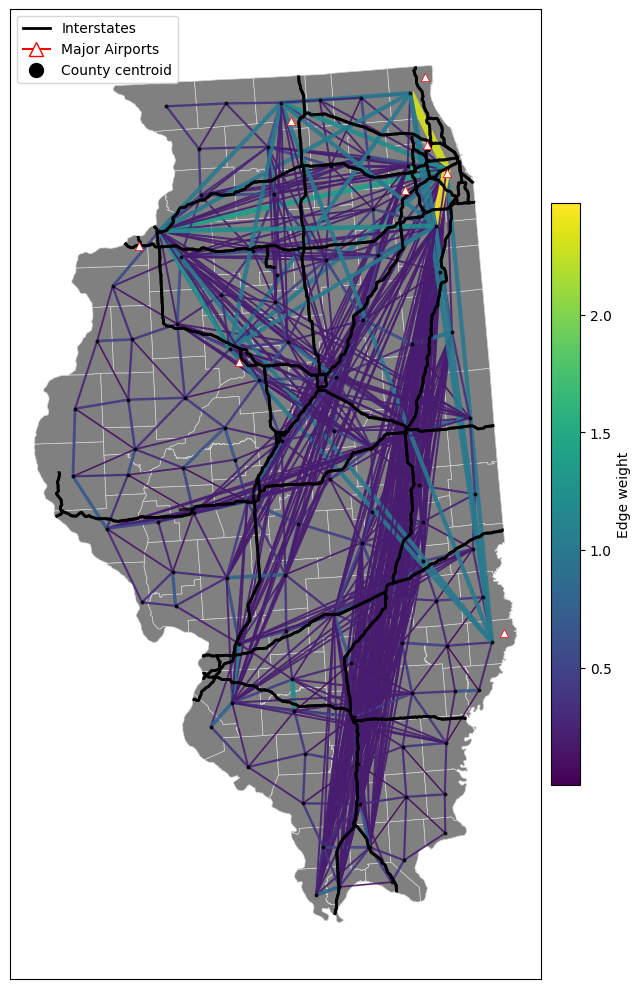

In [120]:
threshold = 0
edges_filtered = [e for e in edges if e[2] >= threshold]

min_w = min([e[2] for e in edges_filtered])
max_w = max([e[2] for e in edges_filtered])

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='grey', edgecolor='lightgray', linewidth=0.5, zorder=1)
interstates.plot(ax=ax, edgecolor='black', linewidth=2, zorder=2)

if edges:
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edgelist=[(u, v) for (u, v, _) in edges_filtered],
        edge_color=[w for _, _, w in edges_filtered],
        width=[1 + 5*(w - min_w)/(max_w - min_w) for _, _, w in edges_filtered],
        alpha=0.9,
        arrows=False
    )

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=8, node_color='black', linewidths=0, alpha=0.9)
if edges:
    sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.01)
    cbar.set_label('Edge weight')

airports.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.5, zorder=3, marker='^')

handles = [
    mlines.Line2D([], [], color='black', linewidth=2, label='Interstates'),
    mlines.Line2D([], [], color='red', marker='^', markersize=10,
                  markerfacecolor='white', label='Major Airports'),
    mlines.Line2D([], [], color='none', marker='o', markersize=10,
                  markerfacecolor='black', label='County centroid')
]

ax.legend(handles=handles, loc='upper left')


ax.set_aspect('equal')
ax.autoscale()
plt.tight_layout()

plt.show()

## Variants

In [89]:
variants = pd.read_csv('../processed data/combined_covariates_interpolated.csv')
variants.head()

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,icu,...,population,location,key_nuts,Alpha,Beta,Delta,Epsilon,Gamma,Iota,Omicron
0,2021-04-19,8195.0,146.0,NaN,NaN,NaN,26456.0,21371.0,NaN,NaN,...,65435.0,17001,NaN,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0
1,2021-04-20,8212.0,146.0,NaN,NaN,NaN,26484.0,21396.0,NaN,NaN,...,65435.0,17001,NaN,0.083333,0.0,0.0,0.0,0.611111,0.0,0.0
2,2021-04-21,8231.0,146.0,NaN,NaN,NaN,26535.0,21581.0,NaN,NaN,...,65435.0,17001,NaN,0.166667,0.0,0.0,0.0,0.555556,0.0,0.0
3,2021-04-22,8243.0,146.0,NaN,NaN,NaN,26579.0,21705.0,NaN,NaN,...,65435.0,17001,NaN,0.250000,0.0,0.0,0.0,0.500000,0.0,0.0
4,2021-04-23,8254.0,146.0,NaN,NaN,NaN,26636.0,21868.0,NaN,NaN,...,65435.0,17001,NaN,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0


In [94]:
variants.groupby('location')['confirmed'].diff()

0         NaN
1        17.0
2        19.0
3        12.0
4        11.0
         ... 
90205    20.0
90206    12.0
90207     0.0
90208     0.0
90209    17.0
Name: confirmed, Length: 90210, dtype: float64

In [ ]:
# .mul(variants.confirmed, axis=0)